# Exercise Series (Week 1/4)

Investigate a accuracy of a numerical time integration method for the Lorenz system, and for the Dahlquist test equation.

1. [Lorentz System](#lorenz-system)
2. [Dahlquist Equation](#dahlquist-equation)

## Lorenz System

We focus on the following system of non-linear ODE, known as the Lorenz system :

$$
\begin{align}
\frac{dx}{dt} &= \sigma(y-x) \\
\frac{dy}{dt} &= x(\rho-z)-y \\
\frac{dz}{dt} &= xy-\beta z
\end{align}
$$

with $(x_0, y_0, z_0) = (20, 5, -5)$ and parameters $\sigma=10$, $\rho=28$ and $\beta=8/2$ such that the system shows a chaotic behavior.

The first step is to implement a generic `ForwardEuler` solver that can be used solve any system of ODE of the form :

$$
\frac{dU}{dt} = f(t,U), \quad t \in [T_0, T_{end}], \quad U(0) = U_0.
$$

We provide a reference implementation in the [`lorenz.py`](./lorenz.py) file, using this function :

```python
t, u = forwardEuler(f, t0, tEnd, u0, nStep)
```

where `f` is a function that evaluate the Right Hand Side (RHS) on any vector and at any time using this signature :

```python
uEval = f(t, u)
```

with `t` the time of the evaluation and `u` the evaluated vector.

Also, `[t0, tEnd]` the time interval, `u0` the initial vector and `nStep` the number of time-steps to us on the simulated time interval. It return a vector with the discrete times `t` and the one with the solution at all time `u`.

1. [First solution and plot of the trajectories](#first-solution-and-plot-of-the-trajectories)
2. [First steps toward a converged solution](#first-steps-toward-a-converged-solution)
3. [Evaluate local and global truncation error](#evaluate-local-and-global-truncation-error)


### First solution and plot of the trajectories

> :crossed_swords: You can try, as an exercise, to implement yourself the `forwardEuler` function without looking at its given implementation.

First, we define the RHS function for the Lorentz System :

In [1]:
sigma = 10; rho = 28; beta=8/3

def rhsLorentz(t, u):
    x, y, z = u
    return sigma*(y-x), x*(rho-z)-y, x*y-beta*z


Then compute a numerical solution on $t\in[0, 20]$ using $nStep=20000$ and plot the result using some utility function defined in the `lorentz.py` module :

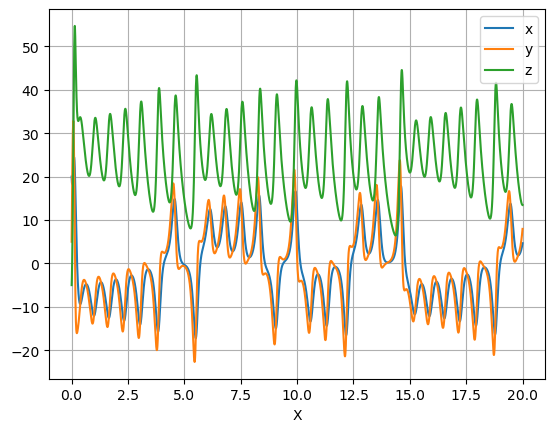

In [2]:
from lorenz import forwardEuler, plot2DCurve

u0 = [20, 5, -5]; nStep = 20000
t, u = forwardEuler(rhsLorentz, 0, 20, u0, nStep)

plot2DCurve(t, u[0, :], "solution", label="x", xLabel="Time", yLabel="Solution")
plot2DCurve(t, u[1, :], "solution", label="y")
plot2DCurve(t, u[2, :], "solution", label="z")

### First steps toward a converged solution

We selected before a quite high number of time-steps. Let's take it ten time smaller and show the solution again :

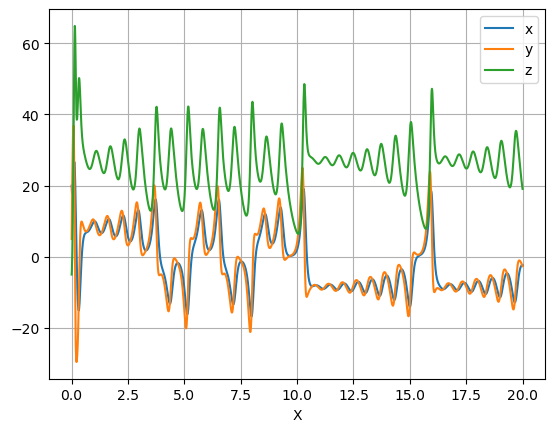

In [3]:
u0 = [20, 5, -5]; nStep = 2000
t, u = forwardEuler(rhsLorentz, 0, 20, u0, nStep)

plot2DCurve(t, u[0, :], "solution", label="x", xLabel="Time", yLabel="Solution")
plot2DCurve(t, u[1, :], "solution", label="y")
plot2DCurve(t, u[2, :], "solution", label="z")

We can observe that the trajectories are note the same anymore ! But as a matter of fact, if multiply the original number of time-steps per 10, then we get a different trajectory already after 4 seconds.

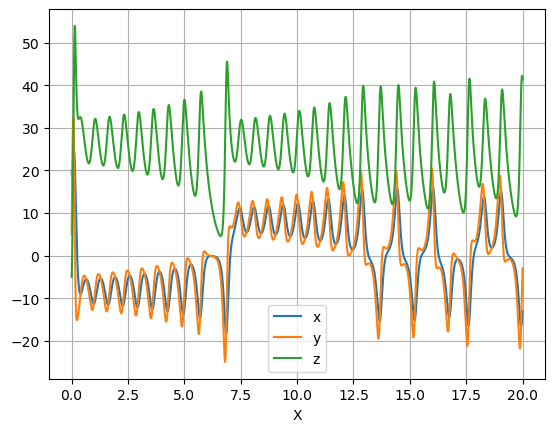

In [4]:
u0 = [20, 5, -5]; nStep = 200000
t, u = forwardEuler(rhsLorentz, 0, 20, u0, nStep)

plot2DCurve(t, u[0, :], "solution", label="x", xLabel="Time", yLabel="Solution")
plot2DCurve(t, u[1, :], "solution", label="y")
plot2DCurve(t, u[2, :], "solution", label="z")

This is a particularity of the Lorentz system, for which a small perturbation can induce very large differences between solutions.
A standard experiment to highlight that is to consider a small perturbation in the solution, here $\tilde{x}(0) = x(0) + \epsilon$ with $\epsilon=1e^{-3}$ :

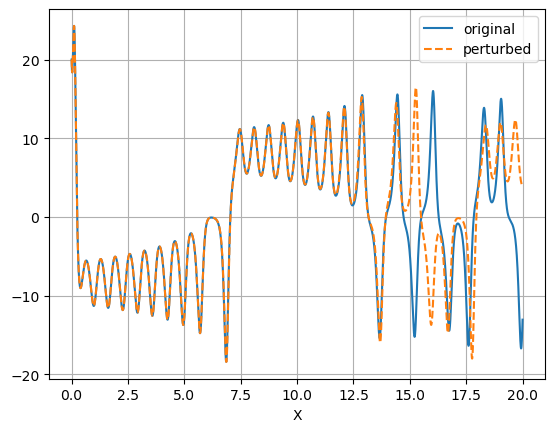

In [5]:
u0 = [20+1e-3, 5, -5]
t, uPert = forwardEuler(rhsLorentz, 0, 20, u0, nStep)
plot2DCurve(t, u[0, :], "perturbation", label="original", xLabel="Time", yLabel="$x(t)$")
plot2DCurve(t, uPert[0, :], "perturbation", label="perturbed", style='--')

We see that even with extremely small time-steps size ($\Delta_t=0.0001$), the perturbation has an impact already after 10 seconds.

This motivates a good estimation / evaluation of the time-discretization to assert that we are accurately solving the problem, already without using a PinT method.

> :crossed_swords: How small should be the perturbation for getting the same trajectory with `nStep=20000` on the whole time interval $[0, 20]$ ? 

### Evaluate local and global truncation error

We want to evaluate here the local and global truncation error for Forward Euler on the Dahlquist system, using the definitions given during the lecture, and the following procedures :

**Local Truncation Error**

1. Set `nStep=1`
2. Choose a reference solution with `nStepRef >> nStep`
3. Choose a list of $\Delta_t$
4. Compute error with reference solution for each time-step size

Here is the associated code :

In [6]:
import numpy as np

# Local error evaluation
nStep = 1
nStepRef = 1000
dt = np.array([0.0001, 0.001, 0.01, 0.1])
lErrLoc = []
for T in dt:
    t, u = forwardEuler(rhsLorentz, 0, T, [20, 5, -5], nStep)
    t, uRef = forwardEuler(rhsLorentz, 0, T, [20, 5, -5], nStepRef)
    err = np.linalg.norm(uRef[:, -1] - u[:, -1])  # Use 2-norm here ...
    lErrLoc.append(err)

**Global Truncation Error**

1. Set a given final time $T$ for all simulations
2. Choose a list of $nStep$ to solve the whole time interval $[0,T]$
3. Choose a reference solution with `nStepRef >> max(nSteps)`
4. Compute error with reference solution for each number of time-steps

Here is the associated code :

In [7]:
# Global error computation
T = max(dt)
lStep = np.array(T/dt, dtype=int)
nStepRef = 100*max(lStep)
t, uRef = forwardEuler(rhsLorentz, 0, T, [20, 5, -5], nStepRef)
lErrGlob = []
for nStep in lStep:
    t, u = forwardEuler(rhsLorentz, 0, T, [20, 5, -5], nStep)
    err = np.linalg.norm(uRef[:, -1] - u[:, -1])
    lErrGlob.append(err)

Now we can plot the errors using the following code :

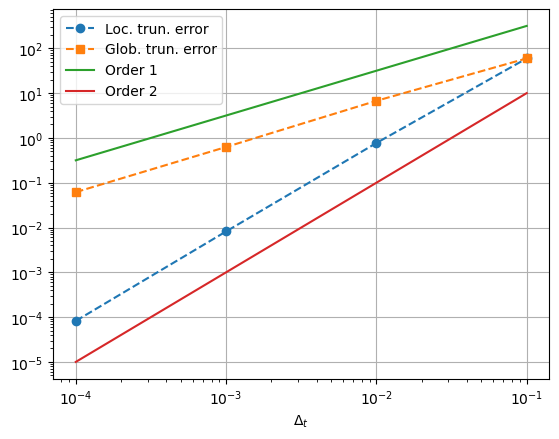

In [8]:
plot2DCurve(dt, lErrLoc, 'Err', 'o--', label='Loc. trun. error')
plot2DCurve(dt, lErrGlob, 'Err', 's--', label='Glob. trun. error')
plot2DCurve(dt, 10**3.5 * dt, 'Err', label='Order 1')
plot2DCurve(dt, 10**3 * dt**2, 'Err', label='Order 2', logX=True, logY=True, xLabel='$\\Delta_t$')

We can observe that local truncation error is order 2, while global truncation error is order 1, as expected by theory. With this kind of evaluation, we can now estimate the time-step size required to solve our problem numerically with a given accuracy. This is essential before trying to apply any PinT algorithm to solve our problem, since it will probably add an additional PinT discretization error, that should be lower than the one we already have with our chosen time-integration method.

> :crossed_swords: Could you estimate the time-step size required to solve the Lorentz system with a $1e^{-3}$ accuracy on te time-domain $T=[0, 20]$ ?

## Dahlquist Equation

We now focus on the Dahlquist equation

$$
\frac{dy}{dt} = \lambda y, \quad y\in\mathbb{C}, \quad t \in [0, T], \quad y(0) = y_0
$$

The objective of this exercises is to implement solvers for this equation using Forward and Backward Euler, and analysis the numerical error done with those time integration methods.

1. [Implementation of Forward and Backward Euler for Dahlquist](#implementation-of-forward-and-backward-euler-for-dahlquist)
2. [Solution Trajectories](#solution-trajectories)
3. [Evaluate Phase and Amplitude Error](#evaluate-phase-and-amplitude-error)

### Implementation of Forward and Backward Euler for Dahlquist

First, we have to provide some generic functions that allows to solve our problem. Here is the proposed code for Forward Euler :

In [9]:
import numpy as np

def dahlquistFE(lam, y0, T, nStep):
    dt = T/nStep
    R = 1+lam*dt
    p = np.arange(nStep+1)
    y = R**p
    y *= y0
    t = np.linspace(0, T, nStep+1)
    return t, y

This function takes $\lambda$, $y_0$ and $T$ as argument, in addition to the number of time-steps `nStep`.
Then, it uses the stability function of Forward Euler, that is :

$$
R(z) = 1 + z
$$

to compute the numerical solution after $p$ steps, which is :

$$
y_{FE}(p\Delta_t) = R(\lambda\Delta_t)^p y_0
$$

We use the same approach for the Backward Euler method :

In [10]:
def dahlquistBE(lam, y0, T, nStep):
    dt = T/nStep
    R = 1/(1-lam*dt)
    p = np.arange(nStep+1)
    y = R**p
    y *= y0
    t = np.linspace(0, T, nStep+1)
    return t, y

> :crossed_swords: Could you implement `dahlquistTrap` that solve the Dahlquist equation with the [Trapezoidal Rule](https://en.wikipedia.org/wiki/Trapezoidal_rule_(differential_equations)) ?

### Solution Trajectories

First, we compute the numerical solution for both time integration method, using one $\lambda$ value :

In [11]:
T = 2*np.pi
y0 = 1
lam = 1j
nStep = 40

t, yFE = dahlquistFE(lam, y0, T, nStep)
t, yBE = dahlquistBE(lam, y0, T, nStep)

... and plot the trajectories in the complex plane, together with the one of the analytical solution :

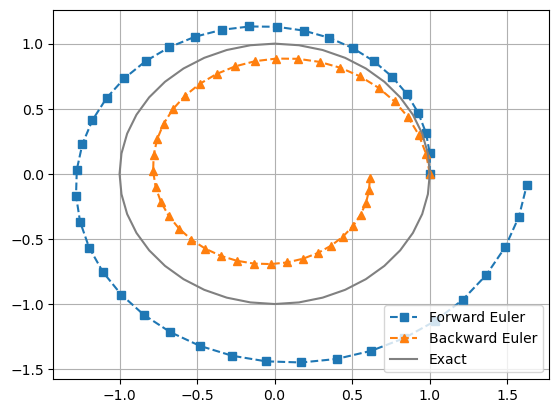

In [12]:
import matplotlib.pyplot as plt

yTh = np.exp(lam*t)

plt.plot(yFE.real, yFE.imag, 's--', label='Forward Euler')
plt.plot(yBE.real, yBE.imag, '^--', label='Backward Euler')
plt.plot(yTh.real, yTh.imag, '-', c='gray', label='Exact')
plt.legend()
plt.grid()

The exact trajectory for $\lambda=i$ is supposed to be a circle, but we observe that the numerical solution shows an amplitude error : while Backward Euler induces some numerical diffusion (reduce the solution amplitude), Forward Euler induces amplification with time (as a matter of fact, Forward Euler is unstable for this value of $\lambda$, which is exactly what we are seeing here ...)

Now if we increase the number of time-steps to reduce the error, and zoom on the final point, here is what we observe :

(-0.002, 0.002)

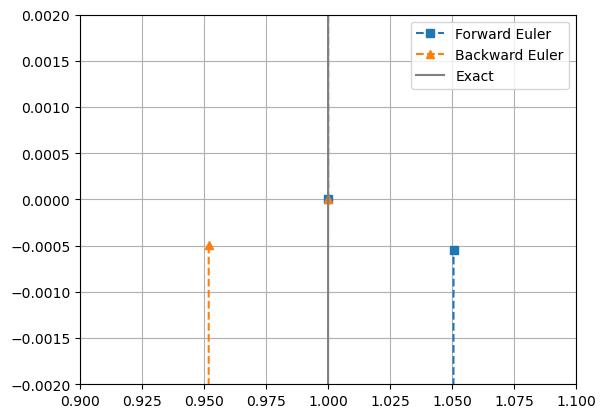

In [13]:
nStep = 400

t, yFE = dahlquistFE(lam, y0, T, nStep)
t, yBE = dahlquistBE(lam, y0, T, nStep)

yTh = np.exp(lam*t)

plt.plot(yFE.real, yFE.imag, 's--', label='Forward Euler')
plt.plot(yBE.real, yBE.imag, '^--', label='Backward Euler')
plt.plot(yTh.real, yTh.imag, '-', c='gray', label='Exact')
plt.legend()
plt.grid()
plt.xlim(0.9, 1.1)
plt.ylim(-0.002, 0.002)

Now we see that the error with amplitude is reduced, but zooming also allows to identify an other error, as the last numerical solution point did not completely finish the full rotation around the origin. 

This is the second component of the numerical error, also called **phase (or dispersion) error**, that we have to investigate in combination with the the **amplitude error** to fully evaluate the accuracy of our time integration scheme.

> :crossed_swords: How could you (artificially) remove any **amplitude error** in Forward (or Backward) euler for $\lambda=i$ and only shows the **phase error** ?

### Evaluate Phase and Amplitude Error

We want to represent amplitude and phase of numerical solution for two $\lambda = i$, and compare it with the analytical solution.

Here is a full code :

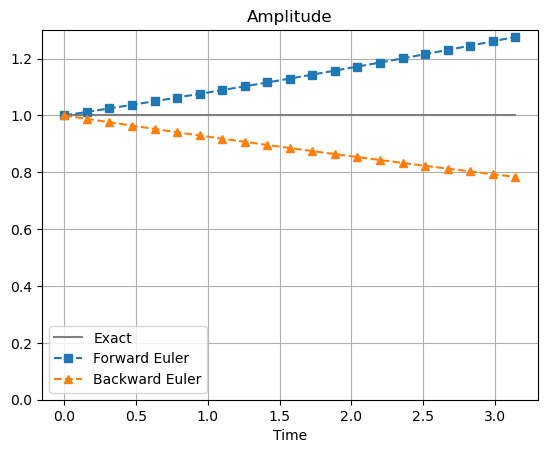

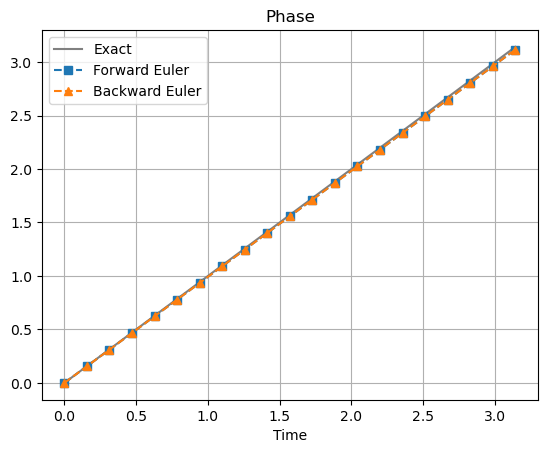

In [14]:
T = np.pi
y0 = 1
nStep = 20
lam = 1j

lC = plt.rcParams['axes.prop_cycle'].by_key()['color']

labelTh = 'Exact'
labelFE = 'Forward Euler'
labelBE = 'Backward Euler'

t, yFE = dahlquistFE(lam, y0, T, nStep)
t, yBE = dahlquistBE(lam, y0, T, nStep)
yTh = np.exp(lam*t)

plt.figure('amplitude')
plt.title('Amplitude')
plt.plot(t, np.abs(yTh), '-', c='gray', label=labelTh)
plt.plot(t, np.abs(yFE), 's--', c=lC[0], label=labelFE)
plt.plot(t, np.abs(yBE), '^--', c=lC[1], label=labelBE)
plt.ylim(0, 1.3)

plt.figure('phase')
plt.title('Phase')
plt.plot(t, np.angle(yTh), '-', c='gray', label=labelTh)
plt.plot(t, np.angle(yFE), 's--', label=labelFE)
plt.plot(t, np.angle(yBE), '^--', label=labelBE)


for figName in ['amplitude', 'phase']:
    plt.figure(figName)
    plt.grid()
    plt.legend()
    plt.xlabel('Time')

As seen before, the phase is well estimated by the numerical method, while the main part in the amplitude error.

But if we change the problem and solve for $\lambda=i-1$ (so, adding some "physical" diffusion in our problem), then we get :

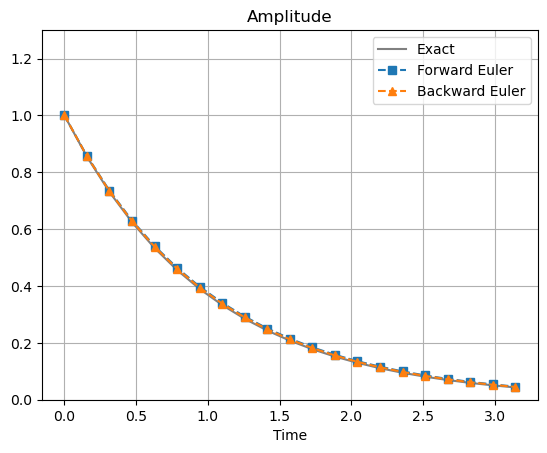

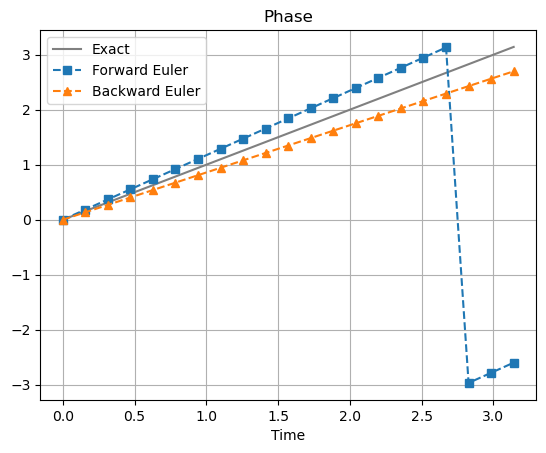

In [15]:
T = np.pi
y0 = 1
nStep = 20
lam = 1j-1

lC = plt.rcParams['axes.prop_cycle'].by_key()['color']

labelTh = 'Exact'
labelFE = 'Forward Euler'
labelBE = 'Backward Euler'

t, yFE = dahlquistFE(lam, y0, T, nStep)
t, yBE = dahlquistBE(lam, y0, T, nStep)
yTh = np.exp(lam*t)

plt.figure('amplitude')
plt.title('Amplitude')
plt.plot(t, np.abs(yTh), '-', c='gray', label=labelTh)
plt.plot(t, np.abs(yFE), 's--', c=lC[0], label=labelFE)
plt.plot(t, np.abs(yBE), '^--', c=lC[1], label=labelBE)
plt.ylim(0, 1.3)

plt.figure('phase')
plt.title('Phase')
plt.plot(t, np.angle(yTh), '-', c='gray', label=labelTh)
plt.plot(t, np.angle(yFE), 's--', label=labelFE)
plt.plot(t, np.angle(yBE), '^--', label=labelBE)


for figName in ['amplitude', 'phase']:
    plt.figure(figName)
    plt.grid()
    plt.legend()
    plt.xlabel('Time')

Now we see that this is inverted ! Main error is done on the phase, while there is not too much amplitude error ...

This stage is also important when studying accuracy of time-integration methods for linear PDE, as those can be seen as a system of Dahlquist problems with many different $\lambda$ values located in specific areas.

> :crossed_swords: Can you evaluate the global error order for phase and amplitude for both $\lambda$ values ?